# piggyBac cell lineage analysis pipeline
* Last updated: Dec 07, 2020
* Author: Ellen DeGennaro
***
### Module 1: Get Pixels:
* Extracts RGB values from original image files and CellProfiler centroid data, and saves to .csv
* From getpixels06saves_mouseedil02_200514
* __Input:__ Cells/CellBodies.csv, Image.csv, pre-processed microscope image .tif
* __Output:__ Dataframe > .csv

### Module 2: Build Cartoon:
* Builds reconstruction of image to verify cell position and colors against original image
* __Input:__ .csv from Module 1
* __Output:__ plots of cell data

### Module 3: Cluster Lineages:
* Uses k-means clustering (recommend checking against Gaussian Mixture models, code not reproduced here) to estimate the number of lineages based on cell RGB color values and x/y positions
* __Input:__ .csv from Module 1
* __Output:__ plots of cell data, sorted by machine learning clusters
***

## Module 1: Get Pixels

In [1]:
#first import the packages we need
#Module 1:
import numpy as np
import csv
import pandas as pd
from PIL import Image

#Module 2 (with those above):
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D

#Module 3 (with those above):
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import seaborn as sns; sns.set()
import matplotlib.cm as cm
from sklearn.preprocessing import MinMaxScaler

__Below are directories and specific file information you'll want to change for different images, analysis runs, and between devices running the code.__

In [4]:
#then store file directories and other info for easy reference later - change these for each image
#microscope image
imgdir = '/Users/ellendegenn/Dropbox (MIT)/Walsh Lab/Borrell collaboration/436g demo/processed images/'
#directory where the cell profiler outputs are located
datadir = '/Users/ellendegenn/Dropbox (MIT)/Walsh Lab/Borrell collaboration/436g demo/CP out/'
#image info for graph titles
title = 'Mouse 436g E14-P22'
#directory where you'll want to save your outputs
savedir = '/Users/ellendegenn/Dropbox (MIT)/Walsh Lab/Borrell collaboration/436g demo/python out/'

Next, need to get information about objects from the CellProfiler outputs:

In [5]:
#first, ask how many objects are there total, from Image.csv
#and store this in variable "objno"
#also good to store the original filename for reference
with open(datadir+'CellID_Image.csv') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        objno = int(float(row['Count_CellBodies']))
        origfilename = row['FileName_Orig']
        
print('No. Obj: ', objno)

No. Obj:  123


Once we know the number of objects, we want to store the x and y coordinates in lists, filled in with values from CellID_CellBodies.csv

In [6]:
#initialize
xcoords = [0 for i in range(objno)]
ycoords = [0 for i in range(objno)]

with open(datadir+'CellID_CellBodies.csv') as csvfile:
    table = pd.read_csv(csvfile, sep=',', header=0, usecols=[2,3])
    #reads in from csv with headers as column names rather than as the first row
    #and only stores columns 2 (x coordinates) and 3 (y coordinates)
    for i in range(0,objno,1):
        xcoords[i] = int(table.values[i,0])
        ycoords[i] = int(table.values[i,1])

And finally, let's open the source image and load in the pixels.

In [8]:
im = Image.open(imgdir+origfilename)
rawpix = im.load()

/Users/ellendegenn/Dropbox (MIT)/Walsh Lab/Borrell collaboration/436g demo/processed images/436g_slide1_sect8_10x_4z_22tile_z3_imjcolor_psdcurves.tif


Next we want to define a function that will fill a new array ("pixels") with averaged color values around the centroid of each cell body identified in CellProfiler. The perimeter around the centroid is defined by `pixperim` and normally is set to 3. It will discard values that are black or close to black - these cells are ether out of frame or incorrectly identified. This function is a mess of conditionals but it works.

In [9]:
#fills pixels array with averaged colors from each point
#updated March 2019
def avgcolors(total, passx, passy, currim, rp):
    pixperim = 3
    for i in range(0,total):        
        current = passx[i], passy[i]
        pcount = 0
        sumtot = [0,0,0]
        mincolor = 60
        for p in range(0,pixperim):
            count = 0
            runtot = [0,0,0]
            currx = current[0]
            curry = current[1]
            if (currim.size[0]-currx-pixperim)==0:
                return
            if (currim.size[1]-currx-pixperim)==0:
                return
            if (current[0] > currim.size[0]):
                return
            if (current[1] > currim.size[1]):
                return
            if sum(rp[currx,curry]) >= mincolor:
                count += 1
                runtot = np.add(runtot,rp[currx,curry])
            if sum(rp[currx+p,curry]) >= mincolor:
                count += 1
                runtot = np.add(runtot,rp[currx,curry])
            if sum(rp[currx,curry+p]) >= mincolor:
                count += 1
                runtot = np.add(runtot,rp[currx,curry])
            if sum(rp[currx-p,curry]) >= mincolor:
                count += 1
                runtot = np.add(runtot,rp[currx,curry])
            if sum(rp[currx,curry-p]) >= mincolor:
                count += 1
                runtot = np.add(runtot,rp[currx,curry])
            if sum(rp[currx+p,curry+p]) >= mincolor:
                count += 1
                runtot = np.add(runtot,rp[currx,curry])
            if sum(rp[currx-p,curry-p]) >= mincolor:
                count += 1
                runtot = np.add(runtot,rp[currx,curry])
            if sum(rp[currx+p,curry-p]) >= mincolor:
                count += 1
                runtot = np.add(runtot,rp[currx,curry])
            if sum(rp[currx-p,curry+p]) >= mincolor:
                count += 1
                runtot = np.add(runtot,rp[currx,curry])
            if count > 0:
                pcount += count #keeps track of the grand total
                sumtot = np.add(sumtot,runtot)
        if pcount > 0:
            pixels[i] = ((sumtot[0]/pcount), (sumtot[1]/pcount), (sumtot[2]/pcount))
            #to lighten can add <30 to each rgb value before storing in pixels
        else:
            pixels[i] = (0,0,0)
            zeroindices.append(i)

Now that we've defined the above function, let's run it on our image!

In [12]:
#first initialize an empty array to store RGB values at each pixel location
pixels = np.empty([objno,3])

#also need to keep track of which pixels are black/emtpy to discard, stored in zeroindices
zeroindices = []

#now call the function with our input data from the image
avgcolors(objno, xcoords, ycoords, im, rawpix)

After all this, the `pixels` array is filled will all pixel values. But because I stored the indices of the blank pixels, I need to use that next to remove those indices from both our `pixels` array and our lists of x and y coordinates. A bit clunky but also works.

In [13]:
colorpix = [] #will be the new pixels
colorpix = np.delete(pixels,zeroindices,0)

xcoords2 = np.delete(xcoords,zeroindices,0)
ycoords2 = np.delete(ycoords,zeroindices,0)
#alternatively, could also overwrite xcoords and ycoords but I prefer not to

At this point it's important to check that everything still matches up in size and that we haven't made any mistakes.

In [17]:
#need to make sure the length of all these is the same
length = len(xcoords2)
if len(xcoords2) != len(ycoords2):
    print('X AND Y MISMATCH')
if len(xcoords2) != len(colorpix):
    print('X AND COLOR MISMATCH')
if len(ycoords2) != len(colorpix):
    print('Y AND COLOR MISMATCH')

If no error was thrown above, we can proceed. The next inelegant step is to pull out the red, green, and blue channel value for each pixel so that they can be saved into an array and exported. This is work revisiting, but for now it works. *__The below block contains the only save function thus far, so comment that out before running if you don't want to overwrite previous analyses!__*

In [22]:
#separate colors
reds = np.zeros(length)
greens = np.zeros(length)
blues = np.zeros(length)
for i in range(0,length):
    reds[i] = colorpix[i][0]
    greens[i] = colorpix[i][1]
    blues[i] = colorpix[i][2]

#put into a complete array before exporting
complete = np.zeros((length,7))
for i in range(0,length):
    complete[i,0] = xcoords2[i]
    complete[i,1] = ycoords2[i]
    complete[i,2] = reds[i]
    complete[i,3] = greens[i]
    complete[i,4] = blues[i]
complete[0,5] = im.size[0]
complete[0,6] = im.size[1]

#get organized to save
headers = ['xcoords', 'ycoords', 'R', 'G', 'B', 'imgsizex', 'imgsizey']

#save to
celltable = pd.DataFrame(complete)
celltable.to_csv(savedir+origfilename[:-4]+'_xyRGB.csv', index=False, header=headers) #save with origfilename, no .tif
#print(celltable)

## Module 2: Build Cartoon
* This module can be omitted, or can be the starting point if Module 1 was previously run, but it is a good sanity check for the first time you are analyzing an image.

Uncomment the lines below (remove both `"""`) if you did not just run Module 1 and want to load previously generated data, stored in `filetoload`

In [52]:
"""
#import packages needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D

#set up your directories again
#microscope image
imgdir = '/Users/ellendegenn/Dropbox (MIT)/Walsh Lab/Borrell collaboration/436g demo/processed images/'
#directory where the cell profiler outputs are located
datadir = '/Users/ellendegenn/Dropbox (MIT)/Walsh Lab/Borrell collaboration/436g demo/CP out/'
#image info for graph titles
title = 'Mouse 436g E14-P22'
#directory where you'll want to save your outputs
savedir = '/Users/ellendegenn/Dropbox (MIT)/Walsh Lab/Borrell collaboration/436g demo/python out/'

filetoload = '/Users/ellendegenn/Dropbox (MIT)/Walsh Lab/Borrell collaboration/436g demo/python out/436g_slide1_sect8_10x_4z_22tile_z3_imjcolor_psdcurves_xyRGB.csv'
#open from
with open(filetoload) as csvfile:
    complete = pd.read_csv(csvfile)
    
xcoords2 = []
for i in range(0,length):
    xcoords2.append(complete[headers[0]][i])

ycoords2 = []
for i in range(0,length):
    ycoords2.append(complete[headers[1]][i])

reds = []
for i in range(0,length):
    reds.append(complete[headers[2]][i])

greens = []
for i in range(0,length):
    greens.append(complete[headers[3]][i])

blues = []
for i in range(0,length):
    blues.append(complete[headers[4]][i])

length = complete.shape[0]

imgsizex = complete[headers[5]][0]
imgsizey = complete[headers[6]][0]

#combine colors into one array
colorpix = np.zeros((length, 3))
for i in range(0, length):
    colorpix[i] = [reds[i], greens[i], blues[i]]
"""


"\n#import packages needed\nimport pandas as pd\nimport numpy as np\nimport matplotlib.pyplot as plt\nimport matplotlib.colors as colors\nfrom mpl_toolkits.mplot3d import Axes3D\n\n#set up your directories again\n#microscope image\nimgdir = '/Users/ellendegenn/Dropbox (MIT)/Walsh Lab/Borrell collaboration/436g demo/processed images/'\n#directory where the cell profiler outputs are located\ndatadir = '/Users/ellendegenn/Dropbox (MIT)/Walsh Lab/Borrell collaboration/436g demo/CP out/'\n#image info for graph titles\ntitle = 'Mouse 436g E14-P22'\n#directory where you'll want to save your outputs\nsavedir = '/Users/ellendegenn/Dropbox (MIT)/Walsh Lab/Borrell collaboration/436g demo/python out/'\n\nfiletoload = '/Users/ellendegenn/Dropbox (MIT)/Walsh Lab/Borrell collaboration/436g demo/python out/436g_slide1_sect8_10x_4z_22tile_z3_imjcolor_psdcurves_xyRGB.csv'\n#open from\nwith open(filetoload) as csvfile:\n    complete = pd.read_csv(csvfile)\n    \nxcoords2 = []\nfor i in range(0,length):\n

In [23]:
#now let's get variables in order to plot
imgsizex = complete[0,5]
imgsizey = complete[0,6]

#separate to simplify plotting
xcs = []
ycs = []
plotcolors = []
for i in range(0,len(colorpix)):
    xcs.append((xcoords2[i]))
    ycs.append((imgsizey-ycoords2[i]))#need to flip for some reason
    plotcolors.append(colorpix[i])

#normalize rgb values to print on graph
normcolors = np.divide(plotcolors,255)
hsvcolors = colors.rgb_to_hsv(normcolors)

And finally, let's plot! First, a representation of the cells in their original positions. Set `s=` at the end of the second line to enlarge the dots for each cell body.

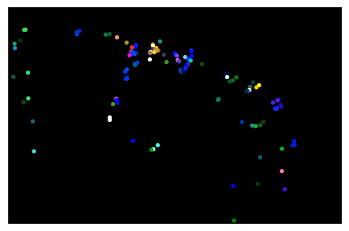

In [25]:
fig, ax = plt.subplots(1,1)
ax.scatter(xcs, ycs, color = normcolors, marker='o', s=10)
#ax.set_xlim([0,(im.size[0])*10])
#ax.set_ylim([0,(im.size[1])*10])
ax.set_xlim([0,im.size[0]])
ax.set_ylim([0,im.size[1]])
ax.set_facecolor('black')
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

#Uncomment below to save
fig.savefig(savedir+origfilename[:-4]+'insitu', dpi = 400, bbox_inches='tight')

Second, let's look at the 3d and 2d representations of RGB and HSV values to get an idea of how well the clustering might go in Module 3.

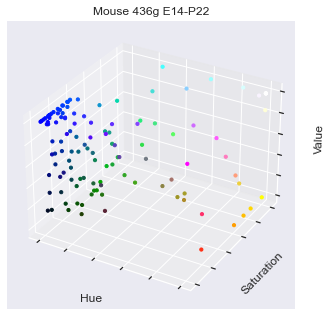

<Figure size 3600x2400 with 0 Axes>

<function matplotlib.pyplot.show(close=None, block=None)>

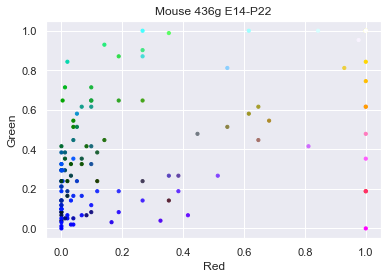

<Figure size 288x144 with 0 Axes>

In [27]:
#3d plot
#see https://matplotlib.org/mpl_toolkits/mplot3d/tutorial.html
fig = plt.figure()
ax = Axes3D(fig)
#ax = fig.add_subplot(111, projection='3d')
 
xs = normcolors[:,0]
ys = normcolors[:,1]
zs = normcolors[:,2]

ax.scatter(xs, ys, zs, c = normcolors, marker='o', s=10, depthshade=False)

ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.yaxis.set_major_formatter(plt.NullFormatter())
ax.zaxis.set_major_formatter(plt.NullFormatter())

ax.set_title(title)
ax.set_xlabel('Hue')
ax.set_ylabel('Saturation')
ax.set_zlabel('Value')
plt.figure(dpi=600)
plt.show()

plt.scatter(xs, ys, c = normcolors, marker='o', s=10)
plt.title(title)
plt.xlabel('Red')
plt.ylabel('Green')
plt.figure(figsize=(4,2))
plt.show

## Module 3: Cluster Lineages

Again, if you are starting from here and loading in previous data, you'll want to uncomment the below code block and run that first.

In [35]:
"""
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import seaborn as sns; sns.set()
import matplotlib.cm as cm
from sklearn.preprocessing import MinMaxScaler

#set up your directories again
#microscope image
imgdir = '/Users/ellendegenn/Dropbox (MIT)/Walsh Lab/Borrell collaboration/436g demo/processed images/'
#directory where the cell profiler outputs are located
datadir = '/Users/ellendegenn/Dropbox (MIT)/Walsh Lab/Borrell collaboration/436g demo/CP out/'
#image info for graph titles
title = 'Mouse 436g E14-P22'
#directory where you'll want to save your outputs
savedir = '/Users/ellendegenn/Dropbox (MIT)/Walsh Lab/Borrell collaboration/436g demo/python out/'

filetoload = '/Users/ellendegenn/Dropbox (MIT)/Walsh Lab/Borrell collaboration/436g demo/python out/436g_slide1_sect8_10x_4z_22tile_z3_imjcolor_psdcurves_xyRGB.csv'
#open from
with open(filetoload) as csvfile:
    complete = pd.read_csv(csvfile)
    
xcoords2 = []
for i in range(0,length):
    xcoords2.append(complete[headers[0]][i])

ycoords2 = []
for i in range(0,length):
    ycoords2.append(complete[headers[1]][i])

reds = []
for i in range(0,length):
    reds.append(complete[headers[2]][i])

greens = []
for i in range(0,length):
    greens.append(complete[headers[3]][i])

blues = []
for i in range(0,length):
    blues.append(complete[headers[4]][i])

length = complete.shape[0]

imgsizex = complete[headers[5]][0]
imgsizey = complete[headers[6]][0]

#combine colors into one array
colorpix = np.zeros((length, 3))
for i in range(0, length):
    colorpix[i] = [reds[i], greens[i], blues[i]]
    
#finally, for plotting
xcs = []
ycs = []
plotcolors = []
for i in range(0,len(colorpix)):
    xcs.append((xcoords2[i]))
    ycs.append((imgsizey-ycoords2[i]))#need to flip for some reason
    plotcolors.append(colorpix[i])

#normalize rgb values to print on graph
normcolors = np.divide(plotcolors,255)
hsvcolors = colors.rgb_to_hsv(normcolors)
"""

"\n#import packages\nimport pandas as pd\nimport numpy as np\nimport matplotlib.pyplot as plt\nimport matplotlib.colors as colors\nfrom sklearn.cluster import KMeans\nimport seaborn as sns; sns.set()\nimport matplotlib.cm as cm\nfrom sklearn.preprocessing import MinMaxScaler\n\n#set up your directories again\n#microscope image\nimgdir = '/Users/ellendegenn/Dropbox (MIT)/Walsh Lab/Borrell collaboration/436g demo/processed images/'\n#directory where the cell profiler outputs are located\ndatadir = '/Users/ellendegenn/Dropbox (MIT)/Walsh Lab/Borrell collaboration/436g demo/CP out/'\n#image info for graph titles\ntitle = 'Mouse 436g E14-P22'\n#directory where you'll want to save your outputs\nsavedir = '/Users/ellendegenn/Dropbox (MIT)/Walsh Lab/Borrell collaboration/436g demo/python out/'\n\nfiletoload = '/Users/ellendegenn/Dropbox (MIT)/Walsh Lab/Borrell collaboration/436g demo/python out/436g_slide1_sect8_10x_4z_22tile_z3_imjcolor_psdcurves_xyRGB.csv'\n#open from\nwith open(filetoload) 

Now let's proceed.

First, I'm going to create two new arrays that contain RGB or HSV value in the same array as the x and y coordinates of cells with those colors. Then I will assign previously determined weights (subject to change!) each of these in order to scale the data for clustering.

In [32]:
colorloc = np.zeros((length, 5))
for i in range(0,length):
    colorloc[i] = [colorpix[i,0], colorpix[i,1], colorpix[i,2],
             xcoords[i], ycoords[i]]

hsvloc = np.zeros((length, 5))
for i in range(0,length):
    hsvloc[i] = [hsvcolors[i,0], hsvcolors[i,1], hsvcolors[i,2],
             xcoords[i], ycoords[i]]
# scale matrix to be between [0,1]
scaler = MinMaxScaler()

#using HSV data with x/y coordinates worked best so this will be the input to the scaled data
#other input options are colorloc, colorpix, or hsvcolors
scaled = scaler.fit_transform(hsvloc)

Because the clustering will take into account the x/y coordinates, we want to weight those less than the HSV colors as we cluter for lineage (since color should matter more than x and y position), so we will adjust those weights below.

In [33]:
#weight for x/ycoords if using xy
w = .03

w_scaled = scaled

w_scaled[:,3] = w*scaled[:,3]
w_scaled[:,4] = w*scaled[:,4]

And since hue is the most important value of color using HSV, we'll also want to weight those accordingly.

In [34]:
w_scaled[:,1] = 0.2*w_scaled[:,1]
w_scaled[:,2] = 0.05*w_scaled[:,2]

Now it's time to calculate the clusters, based on our expected number of clusters, `k`, or `knum`. This is where another module for running Gaussian Mixture Models will be helpful (stay tuned). Alternatively, can explore hierarchical clustering.

In [44]:
knum = 24

calck = KMeans(knum, random_state=0)
clusters = calck.fit(w_scaled).predict(w_scaled)

And finally, let's plot to view our results!

Text(0.5, 1.0, 'N=24 Clusters')

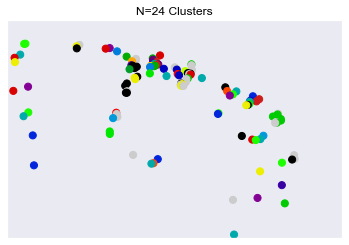

In [45]:
"""
#If Module 2 was not run, uncomment and run this:
xs = normcolors[:,0]
ys = normcolors[:,1]
zs = normcolors[:,2]
"""

#store HSV value separately for ease
hue = hsvcolors[:,0]
sat = hsvcolors[:,1]
hsvalue = hsvcolors[:,2]

#define the color space for plotting clusters
cmap = cm.get_cmap('nipy_spectral')
customcolormap = cmap(np.linspace(0,1,knum))

#let's plot the clusters to compare visually, so each cell is colored according to cluster membership
#in situ
plot, ax1 = plt.subplots()
scatterpl = plt.scatter(xcs, ycs, c=clusters, s=50, cmap='nipy_spectral') #xcs and xs may be the same, will have to fix
ax1.set_xlim([0,imgsizex])
ax1.set_ylim([0,imgsizey])
#ax5is1.set_facecolor('black')
ax1.xaxis.set_visible(False)
ax1.yaxis.set_visible(False)
ax1.set_title('N='+str(knum)+' Clusters', color='black')

#Uncomment below to save
#plot.savefig(savedir+'diffweightHSV/kmeans'+str(knum)+'/'+origfilename[:-4]+'_insitu_clustercolors.svg', dpi = 400, bbox_inches='tight')
#plot.savefig(savedir+'diffweightHSV/kmeans'+str(knum)+'/'+origfilename[:-4]+'_insitu_clustercolors.png', dpi = 400, bbox_inches='tight')

And let's see how that looks in 3d by HSV or RGB

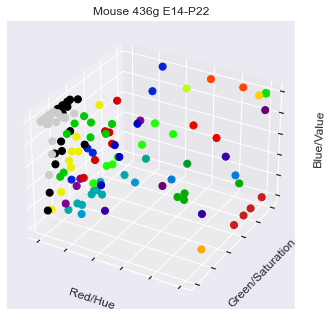

<Figure size 3600x2400 with 0 Axes>

In [46]:
#3dplot
fig = plt.figure()
ax = Axes3D(fig)
#ax = fig.add_subplot(111, projection='3d')

#below shows RGB value on plot, colored according to cluster membership
#comment/uncomment and re-run this cell to toggle
ax.scatter(xs, ys, zs, c = clusters, marker='o', s=50, depthshade=False, cmap='nipy_spectral')

#below shows HSV values on plot, colored according to cluster member ship
#comment/uncomment and re-run this cell to toggle
#ax.scatter(hue, sat, hsvalue, c = clusters, marker='o', s=10, depthshade=False, cmap='nipy_spectral')

#below shows RGB value on plot, colored by RGB colors
#comment/uncomment and re-run this cell to toggle
#ax.scatter(xs, ys, zs, c = normcolors, marker='o', s=10, depthshade=False)

#get the plot settings nice
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.yaxis.set_major_formatter(plt.NullFormatter())
ax.zaxis.set_major_formatter(plt.NullFormatter())

ax.set_title(title)
ax.set_xlabel('Red/Hue')
ax.set_ylabel('Green/Saturation')
ax.set_zlabel('Blue/Value')
plt.figure(dpi=600)
plt.show()

For more visualization, of each cluster on its own, I needed to put everything into pandas DataFrames.

In [47]:
kdata = pd.DataFrame({
        'xcoords' : xcoords2,
        'ycoords' : ycoords2,
        'reds' : xs,
        'greens' : ys,
        'blues' : zs,
        'hue' : hue,
        'sat' : sat,
        'value' : hsvalue,
        'cluster' : clusters})
    
kdata = kdata.sort_values(by=['cluster'])

With the dataframe, it will be easier to look at individual clusters and their attributes. First I'll define some functions to calculate the maximum distance between the two farthest apart cells in one cluster.

In [48]:
#find edges of clusters
def findend(array, k):
    return np.searchsorted(array['cluster'], k, side='right')

#calculate overall max distance
def calcdistance(cells):
    xmax = np.amax(cells)
    xmin = np.amin(cells)
    return (xmax-xmin)

totaldist = calcdistance(xcoords)

#store the edge of the cluster
endsk = []
for i in range(0,knum):
    endsk.append(findend(kdata, i))

#temporarily store each cluster and calculate its differences, store those
diff = []
for i in range(0,knum):
    if i==0:
        temp = kdata['xcoords'][:endsk[i]]
    else:
        temp = kdata['xcoords'][endsk[i-1]:endsk[i]]
    diff.append(calcdistance(temp))

We can also calculate the average distance between clusters, print, and plot these. (Note that the unit will be in pixels. Will have to add metadata from the original image to convert to microns.)

Average Clonal Dispersion Fraction: [0.41332065]
Standard Deviation: [0.33563041]


Text(0.5, 1.0, 'Average Clonal Dispersion')

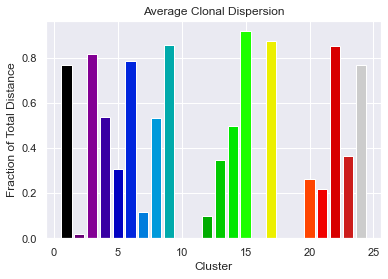

In [49]:
averages = []
stdevs = []
averages.append(np.average(diff))
stdevs.append(np.std(diff))

#normalizing
normavg = averages/totaldist
normstd = stdevs/totaldist
normdiff = diff/totaldist

print('Average Clonal Dispersion Fraction: '+str(normavg))
print('Standard Deviation: '+str(normstd))

#this barplot just shows the average with standard deviation, so isn't super useful
"""
avfig, axav = plt.subplots()
avdata = plt.bar([1], height=normavg, align='center', yerr=normstd, color = ['gray'])
axav.set_ylabel('Fraction of Total Distance')
axav.set_xlabel('Number of Clusters')
axav.xaxis.set_visible(False)
axav.set_title('Average Clonal Dispersion')
#avfig.savefig(savedir+'diffweightHSV/kmeans'+str(knum)+'/'+origfilename[:-4]+'_avg clonal dispersion fraction all barplot.svg', dpi = 400, bbox_inches='tight')
#avfig.savefig(savedir+'diffweightHSV/kmeans'+str(knum)+'/'+origfilename[:-4]+'_avg clonal dispersion fraction all barplot.png', dpi = 400, bbox_inches='tight')
"""

fracfig, axf = plt.subplots()
datafrac = plt.bar(np.arange(1,len(normdiff)+1), height=normdiff, color = customcolormap)
axf.set_ylabel('Fraction of Total Distance')
axf.set_xlabel('Cluster')
axf.set_title('Average Clonal Dispersion')
#fracfig.savefig(savedir+'diffweightHSV/kmeans'+str(knum)+'/'+origfilename[:-4]+'_avg clonal dispersion fraction barplot.svg', dpi = 400, bbox_inches='tight')
#fracfig.savefig(savedir+'diffweightHSV/kmeans'+str(knum)+'/'+origfilename[:-4]+'_avg clonal dispersion fraction barplot.png', dpi = 400, bbox_inches='tight')

Now can sequentially plot each cluster, and calculate the maximal distance of each cluster's spread.

NameError: name 'palplot' is not defined

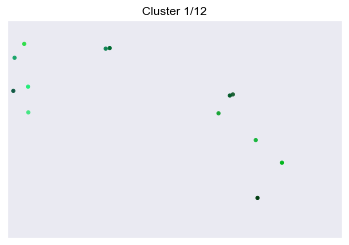

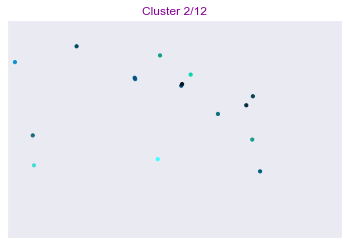

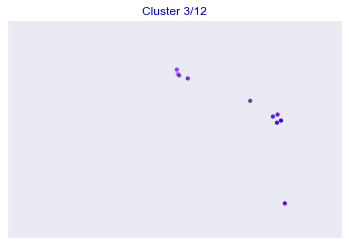

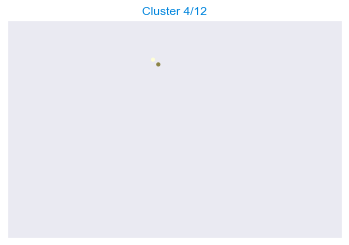

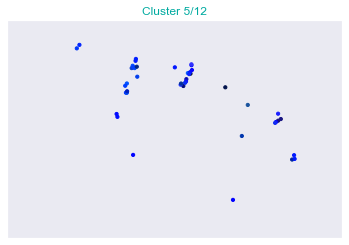

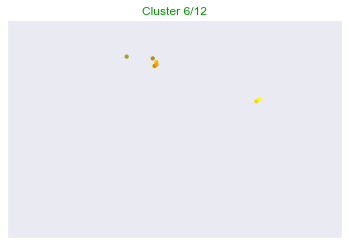

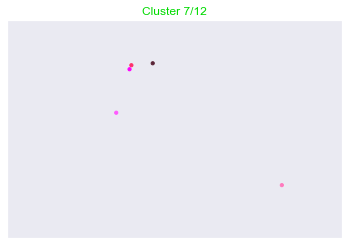

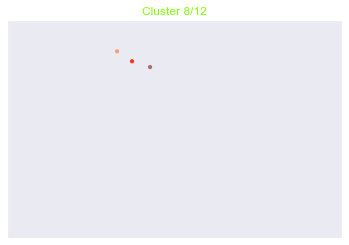

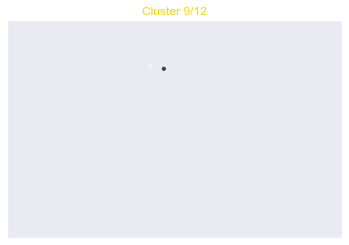

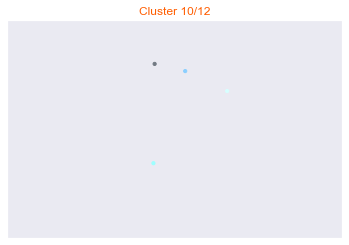

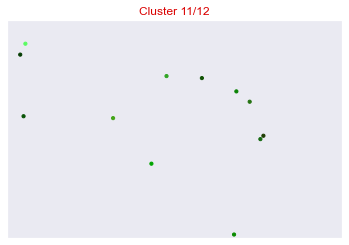

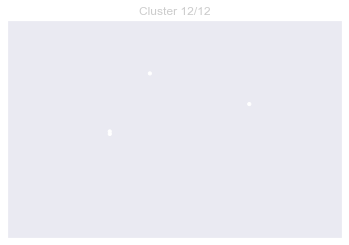

In [43]:
allpals = []
#sequentially plot each cluster
#and load the colors from each cluster for plotting later
for i in range(0,knum):
    #get xyloc and colors
    if i==0:
        xval = kdata['xcoords'][:endsk[i]]
        yval = imgsizey - kdata['ycoords'][:endsk[i]]
        temp = pd.DataFrame({'slicered': kdata['reds'][:endsk[i]],
                         'slicegreen': kdata['greens'][:endsk[i]],
                         'sliceblue': kdata['blues'][:endsk[i]]})
    elif i>0:
        xval = kdata['xcoords'][endsk[i-1]:endsk[i]]
        yval = imgsizey - kdata['ycoords'][endsk[i-1]:endsk[i]]
        temp = pd.DataFrame({'slicered': kdata['reds'][endsk[i-1]:endsk[i]],
                         'slicegreen': kdata['greens'][endsk[i-1]:endsk[i]],
                         'sliceblue': kdata['blues'][endsk[i-1]:endsk[i]]})
    elif i==knum:
        xval = kdata['xcoords'][endsk[i]:]
        yval = imgsizey - kdata['ycoords'][endsk[i]:]
        temp = pd.DataFrame({'slicered': kdata['reds'][endsk[i]:],
                         'slicegreen': kdata['greens'][endsk[i]:],
                         'sliceblue': kdata['blues'][endsk[i]:]})
    
    #convert colors to array for plotting
    localcolors = np.asarray(temp)
    
    palette = np.sort(temp, axis=0)
    allpals.append(palette)
    
    seqsitu, axs = plt.subplots()
    #isplot = plt.scatter(xval, yval, color=customcolormap[i], s=10)
    isplot = plt.scatter(xval, yval, color=localcolors, s=10)
    axs.set_xlim([0,imgsizex])
    axs.set_ylim([0,imgsizey])
    axs.xaxis.set_visible(False)
    axs.yaxis.set_visible(False)
    axs.set_title('Cluster '+str(i+1)+'/'+str(knum), color=customcolormap[i])
    #seqsitu.savefig(savedir+'diffweightHSV/kmeans'+str(knum)+'/'+origfilename[:-4]+'_insitu_origcolors.svg', dpi = 400, bbox_inches='tight')
    #seqsitu.savefig(savedir+'diffweightHSV/kmeans'+str(knum)+'/'+origfilename[:-4]+'_insitu_origcolors.png', dpi = 400, bbox_inches='tight')

#seqentially plot only actual colors by cluster with function call above
for i in range(len(allpals)):
    palplot(allpals[i], 'Cluster '+str(i+1))